In [5]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
puneet6060_intel_image_classification_path = kagglehub.dataset_download('puneet6060/intel-image-classification')

print('Data source import complete.')

100%|██████████| 346M/346M [00:02<00:00, 181MB/s]

Extracting files...


Data source import complete.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob as gb
from tqdm.auto import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from google.colab import files
import zipfile

def download_kaggle_dataset(kaggle_data_path, is_competition=False):
  dataset_name = kaggle_data_path.split("/")[-1]

  # Install Kaggle API
  !pip install -q kaggle

  # Upload the Kaggle API key (kaggle.json)
  from google.colab import files
  files.upload()

  # Move kaggle.json to the .kaggle directory and set proper permissions
  !mkdir -p ~/.kaggle
  !mv kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  # Download the dataset or competition data
  if is_competition:
    !kaggle competitions download -c {kaggle_data_path}
  else:
    !kaggle datasets download -d {kaggle_data_path}

  # Unzip the downloaded dataset into the created folder
  !unzip -q {dataset_name}.zip -d {dataset_name}

  # Delete the zip file after unzipping
  !rm {dataset_name}.zip

def check_and_download_dataset(kaggle_path, colab_path):
  try:
    # Check if dataset is already available in Kaggle
    if gb.glob(pathname=kaggle_path+"*"):
      print("Dataset already available in Kaggle")
      return kaggle_path

    # Check if dataset is already downloaded in Colab
    elif gb.glob(pathname=colab_path+"*"):
      print("Dataset already downloaded in Colab")
      return colab_path

    # Raise an error if the dataset is not found
    raise FileNotFoundError

  except FileNotFoundError:
    # If running in Colab, download the dataset
    import google.colab
    print("Running in Google Colab")
    print("Downloading Kaggle dataset...")
    download_kaggle_dataset("puneet6060/intel-image-classification")
    return colab_path

# Função para carregar imagens de um diretório específico
def carregar_imagens(pasta, max_imagens=None):
    imagens = []
    labels = []

    for subdir in os.listdir(pasta):
        caminho_subdir = os.path.join(pasta, subdir)

        # Verificar se é um diretório
        if os.path.isdir(caminho_subdir):
            print(f"Carregando imagens da categoria: {subdir}")

            for i, nome_imagem in enumerate(os.listdir(caminho_subdir)):
                # Verificar se foi atingido o limite de max_imagens
                if max_imagens is not None and i >= max_imagens:
                    break

                caminho_imagem = os.path.join(caminho_subdir, nome_imagem)

                # Carregar a imagem
                imagem = cv2.imread(caminho_imagem)

                if imagem is not None:
                    imagens.append(imagem)
                    labels.append(subdir)
                else:
                    print(f"Erro ao carregar a imagem: {nome_imagem}")

    return imagens, labels

# Função para visualizar imagens carregadas
def visualizar_imagens(imagens, labels, max_imagens=None):
    print("Visualizando imagens:")

    for i, imagem in enumerate(imagens):
        # Verifica se atingiu o limite de max_imagens
        if max_imagens is not None and i >= max_imagens:
            break

        # Convertendo a imagem de BGR para RGB para exibir corretamente com Matplotlib
        imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

        # Exibir a imagem usando Matplotlib
        plt.imshow(imagem_rgb)
        plt.title(f"Categoria: {labels[i]}")
        plt.axis("off")
        plt.show()

# Função para pré-processar imagens (redimensionar e normalizar)
def preprocessar_imagens(imagens, target_size=(224, 224)):
    imagens_processadas = []

    for imagem in imagens:
        # Redimensionar para 224x224 pixels
        imagem_resized = cv2.resize(imagem, target_size)

        # Normalizar os pixels para o intervalo [0, 1]
        imagem_normalized = imagem_resized / 255.0

        # Converter para array numpy no formato adequado para TensorFlow/PyTorch
        imagem_array = np.array(imagem_normalized, dtype=np.float32)

        imagens_processadas.append(imagem_array)

    return np.array(imagens_processadas)

In [7]:
kaggle_path = "/kaggle/input/intel-image-classification/"
colab_path = "/content/intel-image-classification/"
MAIN_PATH = check_and_download_dataset(kaggle_path, colab_path)

train_path = MAIN_PATH + "seg_train/seg_train/"
test_path = MAIN_PATH + "seg_test/seg_test/"
pred_path = MAIN_PATH + "seg_pred/seg_pred/"

Running in Google Colab


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 96% 331M/346M [00:01<00:00, 249MB/s]
100% 346M/346M [00:01<00:00, 245MB/s]


Carregando imagens da categoria: forest
Carregando imagens da categoria: street
Carregando imagens da categoria: glacier
Carregando imagens da categoria: mountain
Carregando imagens da categoria: sea
Carregando imagens da categoria: buildings
Carregando imagens da categoria: forest
Carregando imagens da categoria: street
Carregando imagens da categoria: glacier
Carregando imagens da categoria: mountain
Carregando imagens da categoria: sea
Carregando imagens da categoria: buildings
Visualizando imagens:


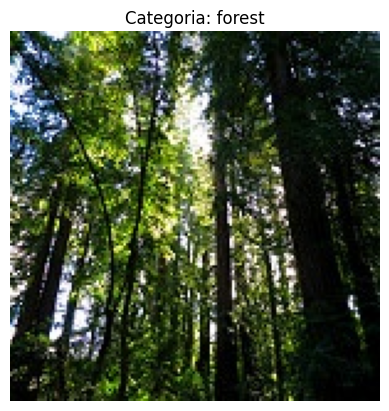

In [9]:
# Carregar imagens de treino e teste
imagens_train, labels_train = carregar_imagens(train_path)
imagens_test, labels_test = carregar_imagens(test_path)

# Visualizar imagens carregadas
visualizar_imagens(imagens_train, labels_train, max_imagens=1)



### Modelling


In [10]:
# Pré-processar os conjuntos de imagens
X_train = preprocessar_imagens(imagens_train, target_size=(100, 100))
X_test = preprocessar_imagens(imagens_test, target_size=(100, 100))

In [11]:
# Codificar as classes
le = LabelEncoder()
labels_encoded_train = le.fit_transform(labels_train)
labels_encoded_test = le.transform(labels_test)  # Usar o mesmo encoder
y_train = to_categorical(labels_encoded_train)
y_test = to_categorical(labels_encoded_test)

In [12]:
# Criar a arquitetura da CNN
def criar_modelo_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(labels_train)), activation='softmax'))
    return model

In [13]:
# Criar e compilar o modelo
input_shape = (100, 100, 3)  # Resolução e canais de cor
modelo = criar_modelo_cnn(input_shape)
modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Treinar o modelo
modelo.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Avaliar o desempenho do modelo
loss, accuracy = modelo.evaluate(X_test, y_test)
print(f"Acurácia do modelo: {accuracy:.2f}")

Epoch 1/10
439/439 [==============================] - 27s 60ms/step - loss: 1.0762 - accuracy: 0.5754 - val_loss: 0.8288 - val_accuracy: 0.6830
Epoch 2/10
439/439 [==============================] - 25s 56ms/step - loss: 0.7742 - accuracy: 0.7136 - val_loss: 0.6190 - val_accuracy: 0.7717
Epoch 3/10
439/439 [==============================] - 24s 54ms/step - loss: 0.6447 - accuracy: 0.7736 - val_loss: 0.5602 - val_accuracy: 0.7943
Epoch 4/10
439/439 [==============================] - 23s 53ms/step - loss: 0.5698 - accuracy: 0.7978 - val_loss: 0.5424 - val_accuracy: 0.8083
Epoch 5/10
439/439 [==============================] - 24s 55ms/step - loss: 0.5059 - accuracy: 0.8211 - val_loss: 0.5320 - val_accuracy: 0.8037
Epoch 6/10
439/439 [==============================] - 24s 55ms/step - loss: 0.4545 - accuracy: 0.8401 - val_loss: 0.4822 - val_accuracy: 0.8300
Epoch 7/10
439/439 [==============================] - 25s 57ms/step - loss: 0.4024 - accuracy: 0.8560 - val_loss: 0.5172 - val_accuracy:

In [16]:
# Função para prever a classe de uma nova imagem
def prever_imagem(caminho_imagem, modelo):
    imagem = cv2.imread(caminho_imagem)
    imagem = cv2.resize(imagem, (100, 100)) / 255.0
    imagem_array = np.expand_dims(imagem, axis=0)  # Adicionar uma nova dimensão
    predicao = modelo.predict(imagem_array)
    classe_predita = le.inverse_transform([np.argmax(predicao)])
    return classe_predita[0]

1/1 [==============================] - 0s 26ms/step


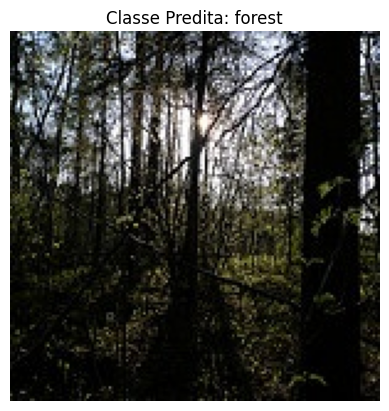

In [20]:
# Exemplo de previsão para uma nova imagem
nova_imagem_path = "/content/intel-image-classification/seg_pred/seg_pred/10261.jpg"  # Altere para o caminho de sua nova imagem
classe_predita = prever_imagem(nova_imagem_path, modelo)
imagem = cv2.imread(nova_imagem_path)
# Converter a imagem de BGR para RGB para exibição correta com matplotlib
imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
plt.imshow(imagem_rgb)
plt.title(f"Classe Predita: {classe_predita}")
plt.axis('off')  # Ocultar os eixos
plt.show()


In [22]:
# Caminho para salvar o modelo
save_dir = "models/cnn"

# Crie o diretório, se não existir
os.makedirs(save_dir, exist_ok=True)

# Caminho completo do arquivo do modelo
model_path = os.path.join(save_dir, "modelo_cnn.h5")

# Supondo que seu modelo CNN esteja treinado e armazenado na variável `model`
modelo.save(model_path)

print(f"Modelo salvo em: {model_path}")

Modelo salvo em: models/cnn/modelo_cnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Transfer Learning

In [23]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Carregar o modelo VGG16 pré-treinado sem a última camada de classificação
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(100, 100, 3))

# Congelar as camadas do modelo base
for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 [==============================] - 0s 0us/step


In [26]:
# Adicionar uma nova camada de classificação
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling global
x = Dense(1024, activation="relu")(x)  # Camada totalmente conectada opcional
output_layer = Dense(units=6, activation="softmax")(x)  # Camada de saída

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=output_layer)


In [28]:
from tensorflow.keras.optimizers import Adam

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Treinar o modelo
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


Epoch 1/10
439/439 [==============================] - 81s 183ms/step - loss: 0.8532 - accuracy: 0.7437 - val_loss: 0.5596 - val_accuracy: 0.8043
Epoch 2/10
439/439 [==============================] - 80s 182ms/step - loss: 0.5039 - accuracy: 0.8240 - val_loss: 0.4753 - val_accuracy: 0.8247
Epoch 3/10
439/439 [==============================] - 80s 181ms/step - loss: 0.4461 - accuracy: 0.8425 - val_loss: 0.4326 - val_accuracy: 0.8440
Epoch 4/10
439/439 [==============================] - 80s 183ms/step - loss: 0.4174 - accuracy: 0.8522 - val_loss: 0.4185 - val_accuracy: 0.8457
Epoch 5/10
439/439 [==============================] - 80s 183ms/step - loss: 0.3983 - accuracy: 0.8594 - val_loss: 0.4015 - val_accuracy: 0.8553
Epoch 6/10
439/439 [==============================] - 80s 183ms/step - loss: 0.3826 - accuracy: 0.8636 - val_loss: 0.3944 - val_accuracy: 0.8550
Epoch 7/10
439/439 [==============================] - 79s 181ms/step - loss: 0.3694 - accuracy: 0.8679 - val_loss: 0.3862 - val_ac

In [31]:
# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Acurácia no conjunto de teste: {accuracy:.2f}")


94/94 [==============================] - 14s 150ms/step - loss: 0.3714 - accuracy: 0.8687
Acurácia no conjunto de teste: 0.87


1/1 [==============================] - 0s 155ms/step


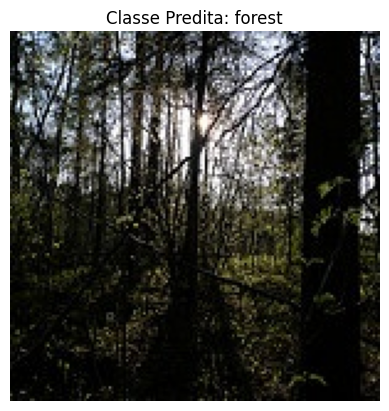

In [32]:
# Exemplo de previsão para uma nova imagem
nova_imagem_path = "/content/intel-image-classification/seg_pred/seg_pred/10261.jpg"  # Altere para o caminho de sua nova imagem
classe_predita_transfer = prever_imagem(nova_imagem_path, model)
imagem = cv2.imread(nova_imagem_path)
# Converter a imagem de BGR para RGB para exibição correta com matplotlib
imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
plt.imshow(imagem_rgb)
plt.title(f"Classe Predita: {classe_predita_transfer}")
plt.axis('off')  # Ocultar os eixos
plt.show()

In [ ]:
# Caminho para salvar o modelo
save_dir = "models/transfer"

# Crie o diretório, se não existir
os.makedirs(save_dir, exist_ok=True)

# Caminho completo do arquivo do modelo
model_path = os.path.join(save_dir, "modelo_transfer.h5")

# Supondo que seu modelo CNN esteja treinado e armazenado na variável `model`
modelo.save(model_path)

print(f"Modelo salvo em: {model_path}")

In [33]:
# Caminho para salvar o modelo
save_dir = "models/transfer"

# Crie o diretório, se não existir
os.makedirs(save_dir, exist_ok=True)

# Caminho completo do arquivo do modelo
model_path = os.path.join(save_dir, "modelo_transfer.h5")

# Supondo que seu modelo transfer esteja treinado e armazenado na variável model
model.save(model_path)

print(f"Modelo salvo em: {model_path}")

Modelo salvo em: models/transfer/modelo_transfer.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
